In [212]:
from error_prop_tools import *
import pyzx as zx
import numpy as np
import scipy as sp
import sympy as sy
import random
import matplotlib.pyplot as plt
from fractions import Fraction
import quimb.tensor as qtn
import pprint as pp
import re
from matplotlib.patches import Circle

--- Generated Grid Map for d=3 ---
[[0, 0, 'X0', 0, 0, 0, 0],
 [0, 'd0', 0, 'd1', 0, 'd2', 0],
 [0, 0, 'Z0', 0, 'X1', 0, 'Z1'],
 [0, 'd3', 0, 'd4', 0, 'd5', 0],
 ['Z2', 0, 'X2', 0, 'Z3', 0, 0],
 [0, 'd6', 0, 'd7', 0, 'd8', 0],
 [0, 0, 0, 0, 'X3', 0, 0]]


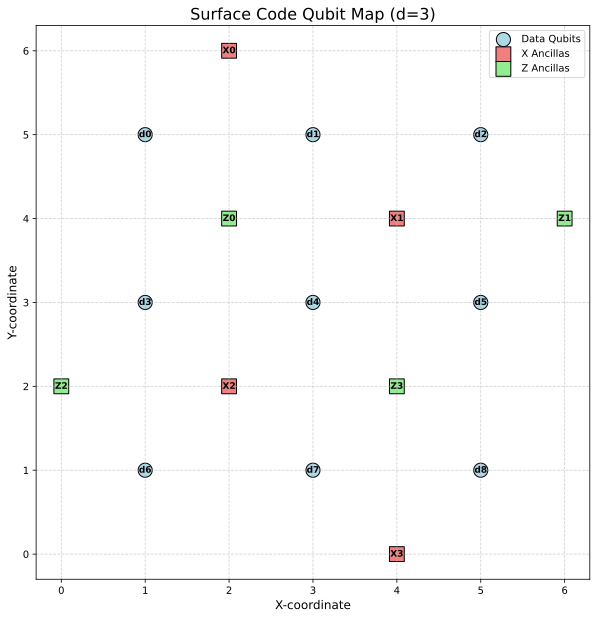

In [213]:
DISTANCE = 3

_, sorted_ancillas = generate_pyzx_and_plot_rotated_code(DISTANCE)

pyzx_map_rotated = {2: (1, 5),
                    5: (3, 5),
                    8: (5, 5),
                    1: (1, 3),
                    4: (3, 3),
                    7: (5, 3),
                    0: (1, 1),
                    3: (3, 1),
                    6: (5, 1),
                    12: (2, 6),
                    11: (2, 4),
                    15: (4, 4),
                    16: (6, 4),
                    9: (0, 2),
                    10: (2, 2),
                    14: (4, 2),
                    13: (4, 0),
                    17: (3, 2),
                    }
order = [1, 3, 0, 2]
custom_orders = {
    'Z0': order,
    'X1': order,
    'X2': order,
    'Z3': order
}
custom_qasm_string = generate_surface_code_qasm(DISTANCE, custom_cnot_orderings=custom_orders)

In [214]:
g = zx.sqasm(custom_qasm_string, simplify=False)
zx.id_simp(g)
# g.map_qubits(pyzx_map_rotated)

error = PauliWeb.random(g)

stab_round = g.copy()

corrs, log = PropagatePauliError(stab_round, [(key, value) for key, value in error.es.items()], add_init=False)
outputs_errs = get_output_errors(stab_round, corrs)
stab_round.apply_state('0'*17)
print(outputs_errs)

zx.draw(g, True, pauli_web = error)
noisy_round = corrs.graph_with_errors()
zx.draw(noisy_round, True)
rho = (lambda x : x.adjoint()+x)(noisy_round)

outs = rho.outputs()
ins = rho.inputs()

for i in range(9):
    rho.set_type(outs[i], zx.VertexType.Z)
    rho.set_type(ins[i], zx.VertexType.Z)
    rho.add_edge((outs[i], ins[i]))

zx.full_reduce(rho)
gg = rho.copy()
gg.normalize()
zx.draw(gg, True)    

sample = np.abs(np.real(np.diag(rho.to_matrix(preserve_scalar=True))))
pp.pprint(np.sum(sample))

{65: 'Z', 67: 'X', 69: 'Y', 72: 'X', 75: 'X', 77: 'X', 79: 'X', 80: 'Y', 81: 'X'}


np.float64(0.9999999999999982)


In [224]:
import numpy as np

def sample_bitstrings(prob_vector, n_samples):
    """
    Samples bitstrings based on the given probability vector.

    Parameters:
        prob_vector (numpy.ndarray): A vector where each entry represents the probability of a bitstring.
        n_samples (int): The number of samples to generate.

    Returns:
        list: A list of sampled bitstrings.
    """
    # Ensure the probabilities sum to 1
    prob_vector = prob_vector / np.sum(prob_vector)
    
    # Generate indices based on the probability vector
    sampled_indices = np.random.choice(len(prob_vector), size=n_samples, p=prob_vector)
    
    # Convert indices to bitstrings
    bit_length = int(np.log2(len(prob_vector)))
    sampled_bitstrings = [format(idx, f'0{bit_length}b') for idx in sampled_indices]
    
    return sampled_bitstrings

n_samples = 5
samples = sample_bitstrings(sample, n_samples)
print(samples)

['01010111', '11010011', '11110110', '01110010', '11110110']


16


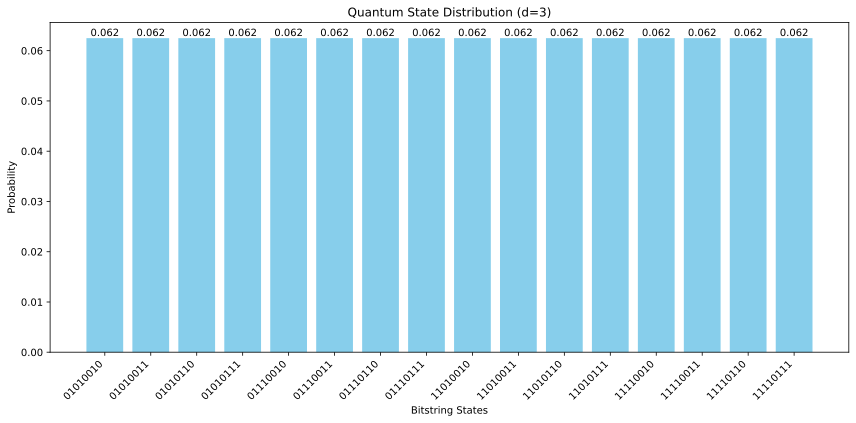

In [216]:
import matplotlib.pyplot as plt
import numpy as np

probs = np.abs(sample.real)
threshold = 1e-10
significant_indices = np.where(probs > threshold)[0]
significant_probs = probs[significant_indices]
print(len(significant_probs))

# Generate bitstrings for the significant indices
significant_bitstrings = [format(idx, f'0{int(np.log2(len(sample)))}b') for idx in significant_indices]

# Create a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(significant_probs)), significant_probs, color='skyblue')

# Customize the plot
plt.xlabel('Bitstring States')
plt.ylabel('Probability')
plt.title(f'Quantum State Distribution (d={DISTANCE})')
plt.xticks(range(len(significant_probs)), significant_bitstrings, rotation=45, ha='right')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [217]:
qubit_dict = {i: f'd{i}' for i in range(9)}
for i, s in enumerate(['X0', 'Z0', 'X1', 'Z1', 'Z2', 'X2', 'Z3', 'X3']):
    qubit_dict[i+9] = s
plotting_dict = {}
for e in outputs_errs.items():
    plotting_dict[qubit_dict[stab_round.qubit(e[0])]] = e[1]
    print(f"Error on qubit {qubit_dict[stab_round.qubit(e[0])]}: {e[1]}")



Error on qubit d0: Z
Error on qubit d2: X
Error on qubit d4: Y
Error on qubit d7: X
Error on qubit Z0: X
Error on qubit Z1: X
Error on qubit X2: X
Error on qubit Z3: Y
Error on qubit X3: X
